# Question 1
This notebook provides a skeleton for the code you need to submit for Question 1. Using this notebook should guide you through the question and ensure that you're staying on the right track, but it's not necessary that use it to complete the assignment.


First, let's start with some imports. These are all the imports that are needed to complete this question. If you prefer to use different libraries/methods, feel free to add to or replace these imports as you see fit. It's not required that you use these specific packages.

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import layers, wrappers
from keras.layers import Dense, Activation
from sklearn.model_selection import RandomizedSearchCV

from scipy import stats


import matplotlib

Now, let's load the training data and see what we're dealing with.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
training_data = pd.read_csv('/content/drive/MyDrive/Wine Data/wine_training.csv')
training_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.47,0.46,2.2,0.114,7.0,20.0,0.99647,3.32,0.63,10.5,5
1,7.4,0.74,0.07,1.7,0.086,15.0,48.0,0.99502,3.12,0.48,10.0,5
2,14.3,0.31,0.74,1.8,0.075,6.0,15.0,1.00080,2.86,0.79,8.4,6
3,7.5,0.51,0.02,1.7,0.084,13.0,31.0,0.99538,3.36,0.54,10.5,6
4,9.1,0.52,0.33,1.3,0.070,9.0,30.0,0.99780,3.24,0.60,9.3,5


There are 1280 samples with 11 continuous features ('fixed acidity' through to 'alcohol') which you will use to predict the 'quality'.

Load the testing data analogously.

In [4]:
testing_data = pd.read_csv('/content/drive/MyDrive/Wine Data/wine_testing.csv')
testing_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.1,0.530,0.08,1.9,0.077,24,45,0.99528,3.60,0.68,10.3
1,6.2,0.390,0.43,2.0,0.071,14,24,0.99428,3.45,0.87,11.2
2,9.3,0.430,0.44,1.9,0.085,9,22,0.99708,3.28,0.55,9.5
3,7.0,0.735,0.05,2.0,0.081,13,54,0.99660,3.39,0.57,9.8
4,10.7,0.900,0.34,6.6,0.112,23,99,1.00289,3.22,0.68,9.3


There are 320 testing samples with the same 11 features. You will use these features to predict the wine quality.

Before moving on, convert the data to a numpy array and separate the training inputs from the training outputs.

In [16]:
training_numpy = training_data.to_numpy()
testing_numpy = testing_data.to_numpy()

X = training_numpy[:,0:-1]
y = training_numpy[:,-1]
X_test = testing_numpy.copy()

Now is a good time to get a feel for the data. The best way to do this is performs some exploratory data analysis. This involves calulating various statistics on the data and generating plots with the aim of learning as much about the data as possible. The idea is that if you are familiar with the data, it will be easier to analyze results, troubleshoot errors, choose model parameters, etc. Start by calculating the mean and standard deviation of each feature and move on to histograms, correlations, and whatever else you would like to know about the data. Some question you may want to answer before moving forward:
* are there any missing values?
* are there any outliers which could hurt our model?
* can we remove any features becuse they don't add any information?

In general, there is no one right way to do exploratory data analysis. The point is to make sure you are familiar with the data.

In [17]:
'''TODO: Do some exploratory data analysis to get familiar with the data'''
training_data.shape, testing_data.shape

((1280, 12), (320, 11))

In [18]:
training_data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

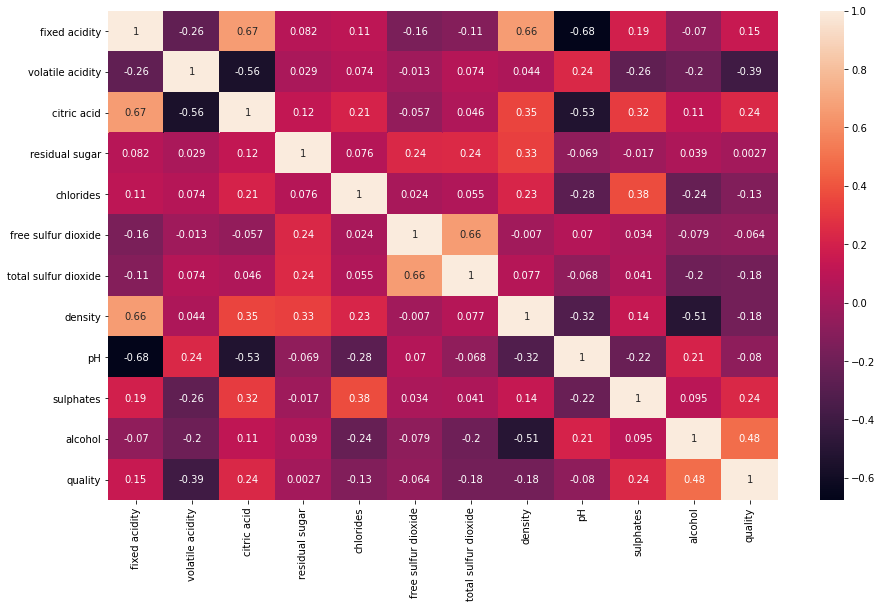

In [19]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(15,9))
sns.heatmap(training_data.corr(), annot=True)

In [20]:
training_data.quality.unique()

array([5, 6, 7, 4, 8, 3])

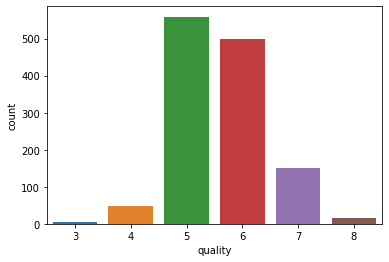

In [21]:
sns.countplot(x='quality', data = training_data)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


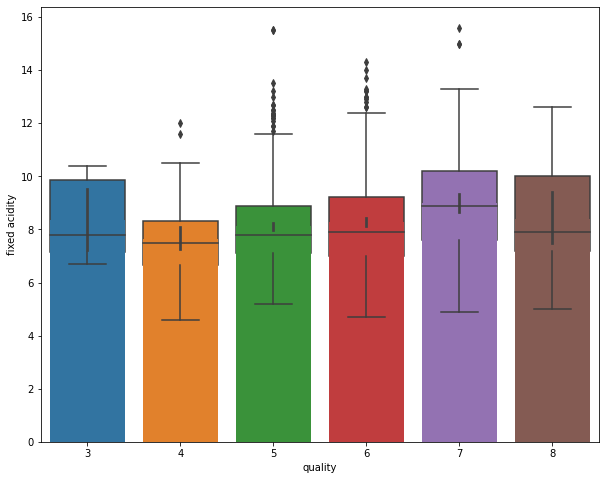

In [22]:
plt.figure(figsize = (10, 8))
sns.boxplot('quality', 'fixed acidity', data = training_data)
sns.barplot('quality', 'fixed acidity', data = training_data)

Checking whether outliers  are present or not

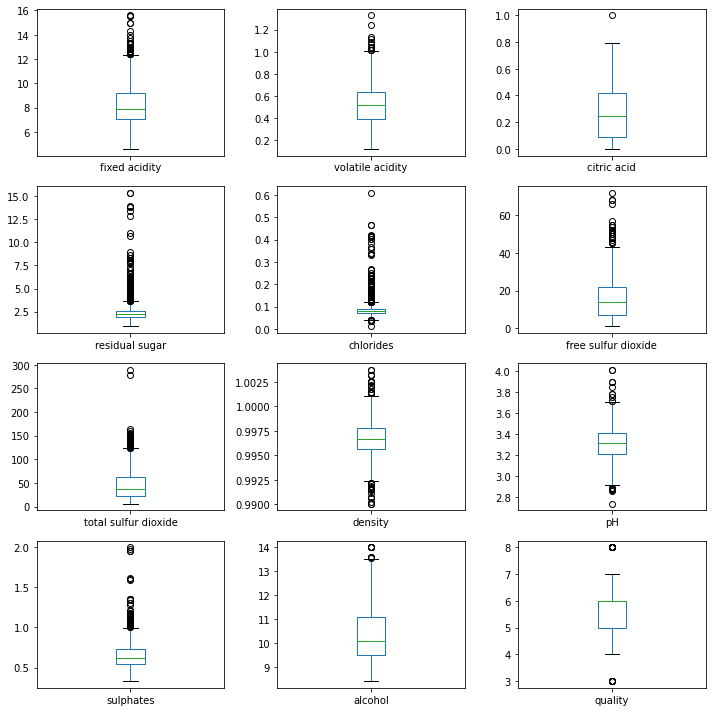

In [23]:
plt.figure(figsize=(10,10)) 
for i,column_name in enumerate(list(training_data.columns.values)):
    plt.subplot(4,3,i+1)
    training_data.boxplot(column_name)
    plt.grid()
    plt.tight_layout()
    

In [24]:
# Removing outliers for better performance
     
def outliers(Column_name):
    Q1, Q3 = Column_name.quantile([0.25, 0.75])
    Mean = Column_name.median()
    IQR = Q3 - Q1
    Lower_boundary = Q1 - (1.5 * IQR)
    upper_boundary = Q3 + (1.5 * IQR)
    return Lower_boundary, upper_boundary,Mean

for Column_name in range(len(training_data.columns)):
    Lower_boundary, upper_boundary,Mean = outliers(training_data.iloc[:, Column_name])
    training_data.iloc[:, Column_name] = np.where(training_data.iloc[:, Column_name] > upper_boundary,upper_boundary, training_data.iloc[:, Column_name])
    training_data.iloc[:,Column_name] = np.where(training_data.iloc[:, Column_name] < Lower_boundary,Lower_boundary, training_data.iloc[:, Column_name])    
       



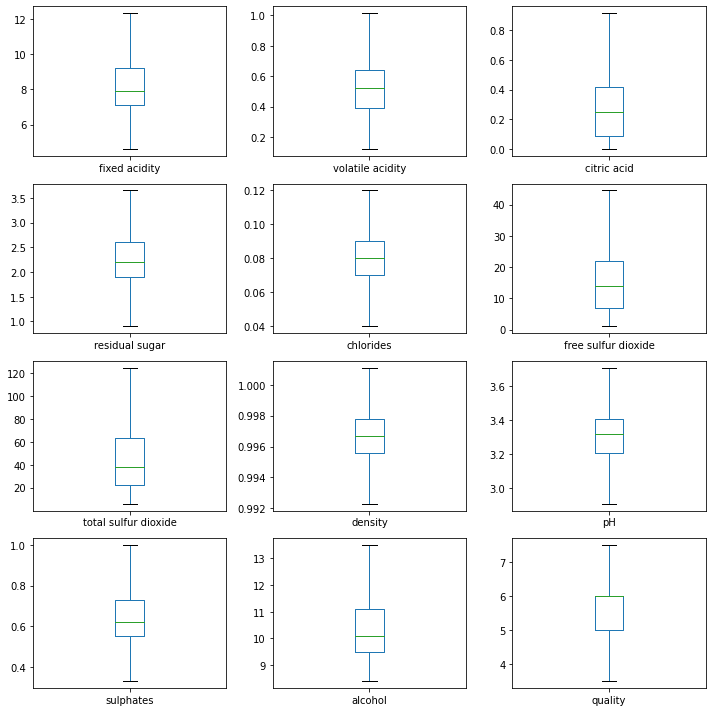

In [25]:
plt.figure(figsize=(10,10)) 
for i,column_name in enumerate(list(training_data.columns.values)):
    plt.subplot(4,3,i+1)
    training_data.boxplot(column_name)
    plt.grid()
    plt.tight_layout()
    

In [26]:
training_data.columns
#training_data=training_data.drop(['residual sugar', 'free sulfur dioxide','pH','chlorides','fixed acidity'], axis=1)
training_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.470,0.46,2.20,0.114,7.0,20.0,0.99647,3.32,0.63,10.5,5.0
1,7.40,0.740,0.07,1.70,0.086,15.0,48.0,0.99502,3.12,0.48,10.0,5.0
2,12.35,0.310,0.74,1.80,0.075,6.0,15.0,1.00080,2.91,0.79,8.4,6.0
3,7.50,0.510,0.02,1.70,0.084,13.0,31.0,0.99538,3.36,0.54,10.5,6.0
4,9.10,0.520,0.33,1.30,0.070,9.0,30.0,0.99780,3.24,0.60,9.3,5.0
5,9.10,0.400,0.57,3.65,0.080,6.0,20.0,0.99652,3.28,0.57,12.5,6.0
6,8.90,0.480,0.53,3.65,0.101,3.0,10.0,0.99586,3.21,0.59,12.1,7.0
7,8.60,0.450,0.31,2.60,0.086,21.0,50.0,0.99820,3.37,0.91,9.9,6.0
8,10.40,0.575,0.61,2.60,0.076,11.0,24.0,1.00000,3.16,0.69,9.0,5.0
9,7.90,0.690,0.21,2.10,0.080,33.0,124.5,0.99620,3.25,0.51,9.9,5.0


In [27]:
training_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
dtype: object

Here we can see the shape has decreased when we removed outliers

In [28]:
training_data.shape

(1280, 12)

Having done some exploratory data analysis, it may be a good idea to preprocess the data. This can be done in many ways and, again, there is no one way which is right. As a minimum, it's a good idea to standardize the features. You can do this using the StandardScaler class in sklearn.

A more powerful and sophisticated method is Principal Component Analysis (PCA) which is discussed in the 09-Unsupervised-Learning-Part2 notebook on eclass.

Standardizing the features

In [30]:
'''TODO: Preprocess the dataset using a method you deem appropriate given the data'''

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
X_test_std = StandardScaler().fit_transform(X_test)
                           

In [31]:
#PCA is applied
from sklearn.decomposition import PCA as sklearnPCA
skl_pca = sklearnPCA(n_components=3)
x_train_pca = skl_pca.fit_transform(X_std)
x_test_pca = skl_pca.fit_transform(X_test_std)

## Part A: Regression

Now that the input features have been preprocessed, you can build the feedforward neural network model for regression. There are several ways to do this in Keras but the easiest way is to use the Sequential class with Dense layers. Below is a skeleton of the code to help you get started. Experiment with different number of layers, layer sizes, activation functions, etc. Remember, if you're ever unsure about how a piece of code works, the documentation is your best friend: https://keras.io/api/

One important question you should answer before building the model is how many outputs should the neural network have given that the task is regression. If the output of the network does not match the training outputs, you will run into errors.

Using the Sequential API is sufficient for his question but if you're interested in creating more complicated models, look into Keras' Functional API. The rest of this notebook is written using the Sequential API.

Note: this code is not set up for automated hyperparameter exploration. If you wish to do this, you will need to make some changes such as wrapping model building, training, and evaluation inside for loops which search the hyperparameter space.

In [32]:
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
'''model = Sequential([
    Dense(3, input_dim=3, activation='relu'),
    Dense(16,activation='relu'),
    (Dense(1))
])
'''
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[3]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [35]:
history = model.fit(x_train_pca, y, epochs=30)

Epoch 1/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4509
Epoch 2/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4342
Epoch 3/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4483
Epoch 4/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4337
Epoch 5/30
40/40 [==============================] - 0s 984us/step - loss: 0.4437
Epoch 6/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4398
Epoch 7/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4281
Epoch 8/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4398
Epoch 9/30
40/40 [==============================] - 0s 2ms/step - loss: 0.4270
Epoch 10/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4358
Epoch 11/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4516
Epoch 12/30
40/40 [==============================] - 0s 1ms/step - loss: 0.4274
Epoch 13/30
40/40 [============================

Hyper parameter Tuning

In [36]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[3]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [37]:
kr = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [39]:
kr.fit(x_train_pca, y, epochs=100)

Epoch 1/100
40/40 [==============================] - 0s 2ms/step - loss: 22.2760
Epoch 2/100
40/40 [==============================] - 0s 992us/step - loss: 3.4974
Epoch 3/100
40/40 [==============================] - 0s 994us/step - loss: 1.9716
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 1.5238
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: 1.3672
Epoch 6/100
40/40 [==============================] - 0s 1ms/step - loss: 1.0260
Epoch 7/100
40/40 [==============================] - 0s 1ms/step - loss: 0.9624
Epoch 8/100
40/40 [==============================] - 0s 1ms/step - loss: 0.8541
Epoch 9/100
40/40 [==============================] - 0s 986us/step - loss: 0.8111
Epoch 10/100
40/40 [==============================] - 0s 1ms/step - loss: 0.6937
Epoch 11/100
40/40 [==============================] - 0s 945us/step - loss: 0.6786
Epoch 12/100
40/40 [==============================] - 0s 1ms/step - loss: 0.6543
Epoch 13/100
40/40 [========

In [40]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(kr, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(x_train_pca, y, epochs=100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=4, n_hidden=1, learning_rate=0.022174573948353458 .....
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


27/27 [==============================] - 0s 1ms/step - loss: 12.2161
Epoch 2/100
27/27 [==============================] - 0s 997us/step - loss: 1.1154
Epoch 3/100
27/27 [==============================] - 0s 930us/step - loss: 0.5358
Epoch 4/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4479
Epoch 5/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4279
Epoch 6/100
27/27 [==============================] - 0s 1000us/step - loss: 0.4623
Epoch 7/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4399
Epoch 8/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4743
Epoch 9/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4408
Epoch 10/100
27/27 [==============================] - 0s 2ms/step - loss: 0.4501
Epoch 11/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4407
Epoch 12/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4560
Epoch 13/100
27/27 [=====================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
27/27 [==============================] - 0s 1ms/step - loss: 0.3818
Epoch 39/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4305
Epoch 40/100
27/27 [==============================] - 0s 2ms/step - loss: 0.4455
Epoch 41/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4100
Epoch 42/100
27/27 [==============================] - 0s 2ms/step - loss: 0.4146
Epoch 43/100
27/27 [==============================] - 0s 2ms/step - loss: 0.3945
Epoch 44/100
27/27 [==============================] - 0s 1ms/step - loss: 0.3688
Epoch 45/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4172
Epoch 46/100
27/27 [==============================] - 0s 2ms/step - loss: 0.4014
Epoch 47/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4055
Epoch 48/100
27/27 [==============================] - 0s 1ms/step - loss: 0.4363
Epoch 49/100
27/27 [==============================] - 0s 2ms/step - los

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.4min finished


40/40 [==============================] - 0s 2ms/step - loss: 22.6497
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 3.0232
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 2.0535
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 1.7051
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 1.5948
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 1.2402
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 1.1426
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 1.0497
Epoch 9/100
40/40 [==============================] - 0s 3ms/step - loss: 0.9806
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.8475
Epoch 11/100
40/40 [==============================] - 0s 2ms/step - loss: 0.7928
Epoch 12/100
40/40 [==============================] - 0s 2ms/step - loss: 0.7754
Epoch 13/100
40/40 [============================

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f243b385b50>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.000392002...
                                                          0.0024505367684280487,
                                                          0.011155092541719619,
                                                          0.0007

In [41]:
rnd_search_cv.best_params_

{'learning_rate': 0.0016535051383872363, 'n_hidden': 2, 'n_neurons': 70}

In [42]:
rnd_search_cv.best_score_

-0.445735901594162

In [44]:
model=rnd_search_cv.best_estimator_.model

KFold

In [46]:
kf = KFold(n_splits=10)
for fold_train_idx, fold_val_idx in kf.split(x_train_pca):
    X_train , X_valid = x_train_pca[fold_train_idx,:],x_train_pca[fold_val_idx,:]
    y_train , y_valid = y[fold_train_idx],y[fold_val_idx]
    model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))
    print(model.evaluate(X_valid,y_valid))

Epoch 1/50
36/36 [==============================] - 0s 6ms/step - loss: 0.4134 - val_loss: 0.3988
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.4146 - val_loss: 0.4023
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4143 - val_loss: 0.4025
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4137 - val_loss: 0.4029
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4144 - val_loss: 0.4018
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.4135 - val_loss: 0.4040
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4123 - val_loss: 0.4045
Epoch 8/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4121 - val_loss: 0.4087
Epoch 9/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4137 - val_loss: 0.4059
Epoch 10/50
36/36 [==============================] - 0s 2ms/step - loss: 0.4127 - val_loss: 0.4049
Epoch 11/50
36/36 [

Now that the model has been built and compiled, it is ready to train. To ensure that the model does not overfit to the training data, it's best to perform 10-fold cross-validation. This part has been set up for you using the KFold class.

Two methods which are useful for this step are model.fit(...) and model.evaluate(...).

Now that the model is trained, we can use it to predict the quality of the wine for the testing data. Note that any preprocessing steps you applied to the training data, you will also have to apply to the testing data. Consider using model.predict(...) for this step.

In [47]:
from sklearn.metrics import mean_squared_error
pred=model.predict(x_test_pca)
df = pd.DataFrame(data=pred, columns=["quality"])
df.to_csv('mp2_T1_new.csv',index=False)

## Part 2: Classification

The first step in classification is to divide the training data into its three classes. Recall that the classes are:

* wine belongs to class 'Good' if quality >= 7
* wine belongs to class 'Average' if 7 > quality >= 5
* wine belongs to class 'Bad' if 5 > quality


It's imporant to remember that the task of regression is not the same as classification. As such, using three ordinal classes such as ['Bad' = 1, 'Average' = 2, 'Good' = 3] is not appropriate. To understand the intuition behind this, ask yourself what value should the model predict if it assigns a 50% probability that a wine is 'Bad', a 0% probability that a wine is 'Average', and a 50% probability that a wine is 'Good'. Answering this question is a first step in developing an encoding scheme for the classes.

Hint: look at the imports that are included.

In [85]:
'''TODO: Find an encoding scheme which you can use for the three classes and map each of the wines in the training data to its appropriate class'''
from sklearn.preprocessing import OneHotEncoder
training_data1 = training_data
conditions = [
    (training_data1['quality'] < 5),
    (training_data1['quality'] >= 5) & (training_data1['quality'] < 7),
    (training_data1['quality'] >= 7)
    ]

# Creating list of each condition
values = ['Bad','Average','Good']

# create a new column and use np.select to assign values to it using our lists as arguments
training_data1['Quality_index'] = np.select(conditions, values)

#dropping original quality column
training_data1 = training_data1.drop(columns=['quality'])

#label Encoding
training_data1['Quality_index'].replace({"Bad":'0', "Good":'2',"Average":'1'}, inplace=True)
X_test=testing_data

#onehot Encoding
from keras.utils import np_utils
y_train = np_utils.to_categorical(training_data1['Quality_index'])


'\ncx = training_data1.iloc[:,0 :-1]\ntraining_numpy = cx.to_numpy()\ntesting_numpy = testing_data.to_numpy()\ncx_train = training_numpy.copy()\nX_test = testing_numpy.copy()\n\n'

In [86]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [87]:
training_data1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Quality_index
0,7.4,0.47,0.46,2.2,0.114,7.0,20.0,0.99647,3.32,0.63,10.5,1
1,7.4,0.74,0.07,1.7,0.086,15.0,48.0,0.99502,3.12,0.48,10.0,1
2,14.3,0.31,0.74,1.8,0.075,6.0,15.0,1.00080,2.86,0.79,8.4,1
3,7.5,0.51,0.02,1.7,0.084,13.0,31.0,0.99538,3.36,0.54,10.5,1
4,9.1,0.52,0.33,1.3,0.070,9.0,30.0,0.99780,3.24,0.60,9.3,1


In [88]:
training_data1['Quality_index'].value_counts()

1    1059
2     168
0      53
Name: Quality_index, dtype: int64

In [89]:
X_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.1,0.530,0.08,1.9,0.077,24,45,0.99528,3.60,0.68,10.3
1,6.2,0.390,0.43,2.0,0.071,14,24,0.99428,3.45,0.87,11.2
2,9.3,0.430,0.44,1.9,0.085,9,22,0.99708,3.28,0.55,9.5
3,7.0,0.735,0.05,2.0,0.081,13,54,0.99660,3.39,0.57,9.8
4,10.7,0.900,0.34,6.6,0.112,23,99,1.00289,3.22,0.68,9.3


In [90]:
X_train=training_data1.drop('Quality_index',axis=1)
#y_train=training_data1['Quality_index']

In [91]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)


In [94]:
y_train.dtype

dtype('float32')

In [95]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [96]:
X_train_scaled.shape

(1280, 11)

In [97]:
y_train.shape

(1280, 3)

In [98]:
import keras

In [99]:
optimizer = keras.optimizers.SGD( lr = 0.2)


In [101]:
model = Sequential()
model.add(Dense(128, input_dim=11, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
 
model.fit(X_train_scaled, y_train, epochs=200, batch_size=75, verbose=2)


Epoch 1/200
18/18 - 0s - loss: 0.7015 - accuracy: 0.7766
Epoch 2/200
18/18 - 0s - loss: 0.4803 - accuracy: 0.8289
Epoch 3/200
18/18 - 0s - loss: 0.4408 - accuracy: 0.8461
Epoch 4/200
18/18 - 0s - loss: 0.4184 - accuracy: 0.8500
Epoch 5/200
18/18 - 0s - loss: 0.4092 - accuracy: 0.8562
Epoch 6/200
18/18 - 0s - loss: 0.4103 - accuracy: 0.8391
Epoch 7/200
18/18 - 0s - loss: 0.4527 - accuracy: 0.8313
Epoch 8/200
18/18 - 0s - loss: 0.4048 - accuracy: 0.8406
Epoch 9/200
18/18 - 0s - loss: 0.3854 - accuracy: 0.8555
Epoch 10/200
18/18 - 0s - loss: 0.3888 - accuracy: 0.8484
Epoch 11/200
18/18 - 0s - loss: 0.3733 - accuracy: 0.8508
Epoch 12/200
18/18 - 0s - loss: 0.3776 - accuracy: 0.8500
Epoch 13/200
18/18 - 0s - loss: 0.3649 - accuracy: 0.8562
Epoch 14/200
18/18 - 0s - loss: 0.3777 - accuracy: 0.8523
Epoch 15/200
18/18 - 0s - loss: 0.3606 - accuracy: 0.8570
Epoch 16/200
18/18 - 0s - loss: 0.3532 - accuracy: 0.8609
Epoch 17/200
18/18 - 0s - loss: 0.3454 - accuracy: 0.8680
Epoch 18/200
18/18 - 0s

In [102]:
np.random.seed(42)

In [ ]:
estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(model, X_train_scaled, y_train,scoring='accuracy', cv=kfold)
print("Base: %.2f%% " % (results.mean()*100))

In [ ]:
pred

In [113]:
pred=model.predict(X_test)
h=np.argmax(pred, axis=1)
df1 = pd.DataFrame(data=h, columns=["quality"])
df1
df1.to_csv('Classification.csv',index=False)



Having encoded the outputs for the training data, you can now build and compile the model. This can be done the same as before but pay close attention to the model outputs, the activation function in the final layer, and the loss function used.